# Model Evaluation

## Validação Cruzada de Modelos (Cross-Validating Models)

### Objetivo
Avaliar quão bem um modelo de aprendizado supervisionado funciona no **mundo real**, ou seja, em **dados que ele nunca viu antes**.

### Validação Simples (Hold-out)
- Os dados são divididos em **conjunto de treino** e **conjunto de teste**.
- Treina-se o modelo com o conjunto de treino e avalia-se com o teste.
- **Limitações**:
  1. O desempenho depende de como os dados foram divididos.
  2. Nem todos os dados são usados no treinamento ou avaliação.

### Validação Cruzada k-Fold (K-Fold Cross-Validation)
- Os dados são divididos em `k` partes chamadas *folds*.
- O modelo é treinado com `k-1` folds e testado com o fold restante.
- Esse processo se repete `k` vezes, mudando o fold de teste a cada rodada.
- A média dos resultados das `k` rodadas fornece uma estimativa confiável.


### Boas Práticas com K-Fold
1. **Assumir dados independentes** (IID): importante embaralhar os dados (`shuffle=True`).
2. **Estratificação (Stratified K-Fold)**: garante que a proporção de classes no target seja mantida em cada fold (ex: 80% homens, 20% mulheres em cada divisão).
3. **Pré-processamento só com dados de treino**:
   - Calcular média, desvio padrão, normalizações e seleções de features **somente no conjunto de treino**.
   - Aplicar as transformações tanto ao treino quanto ao teste depois.
   - Isso evita *vazamento de dados* (data leakage), que pode comprometer a avaliação.

### Pipelines no scikit-learn
O uso de pipelines facilita a aplicação correta de pré-processamento + treinamento do modelo. E com `cross_val_score`, o scikit-learn automatiza o processo de validação cruzada, utilizando todos os recursos computacionais disponíveis (`n_jobs=-1`).

In [4]:
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [2]:
digits = datasets.load_digits()

features = digits.data
target = digits.target

stdscaler = StandardScaler()

logit = LogisticRegression()

pipeline = make_pipeline(stdscaler, logit)

kf = KFold(n_splits=10, shuffle=True, random_state=1)

results = cross_val_score(pipeline, features, target, cv=kf, scoring="accuracy", n_jobs=-1)

results.mean()

np.float64(0.9699472377405337)

In [3]:
results

array([0.97777778, 0.98888889, 0.96111111, 0.94444444, 0.97777778,
       0.98888889, 0.95555556, 0.98882682, 0.97765363, 0.93854749])

## Baseline Regression Model

### Objetivo

Criar um modelo de regressão simples, que funcione como **referência inicial (baseline)** para avaliar o desempenho de modelos mais sofisticados.

### Solução

Utiliza-se o `DummyRegressor`, da biblioteca **scikit-learn**, que gera previsões com base em estratégias triviais, como a média ou mediana do valor alvo (target).

### Motivação

Modelos de regressão base são úteis para:

- Estabelecer um **ponto de comparação mínimo**.
- Verificar se um modelo real **aprende algo relevante** em comparação com uma estratégia ingênua.
- Simular comportamentos existentes em sistemas legados (exemplo: assumir que todos os clientes gastarão um valor fixo).

### Estratégias disponíveis no `DummyRegressor`

- `mean`: prevê a **média** dos valores do conjunto de treino.
- `median`: prevê a **mediana** dos valores do conjunto de treino.
- `constant`: prevê um valor **constante** definido pelo usuário (`constant=valor`).

### Avaliação com R² (coeficiente de determinação)

Por padrão, o método `.score()` retorna o R², uma métrica que indica a proporção da variância do target explicada pelo modelo

### Exemplo de comparação

- `DummyRegressor (mean)`: R² ≈ -0.001 → desempenho nulo ou inferior a uma previsão trivial.
- `LinearRegression`: R² ≈ 0.63 → explica cerca de 63% da variância dos dados.

### Conclusão

O uso do `DummyRegressor` é uma prática recomendada para:

- Comparar modelos de regressão com uma **base mínima de desempenho**.
- Validar se os modelos treinados apresentam ganhos reais em relação a estratégias simples.
- Justificar a complexidade e os custos computacionais de modelos mais robustos.

In [10]:
from sklearn.datasets import make_regression
from sklearn.dummy import DummyRegressor

features, target = make_regression(n_samples=500, n_features=5, noise=10, random_state=42)

features_train, features_test, target_train, target_test = train_test_split(features, target, random_state=0)

# dummy regressor
dummy = DummyRegressor(strategy='mean')

# treina dummy regressor
dummy.fit(features_train, target_train)

dummy.score(features_test, target_test)

-0.0445013657114155

In [11]:
from sklearn.linear_model import LinearRegression

ols = LinearRegression()
ols.fit(features_train, target_train)
ols.score(features_test, target_test)

0.9917075029164429

#### Essa comparação serve para:

- Validar se seu modelo realmente está aprendendo, ou só reproduz algo trivial.
- Justificar o uso de modelos mais sofisticados (em relatórios, apresentações, etc.).
- Garantir que o desempenho obtido não é fruto do acaso ou de um padrão óbvio.

## Evaluating Binary Classifier Predictions

### Problema

Dado um modelo de classificação treinado, você deseja avaliar a qualidade de suas previsões.

### Solução

Utilize a função `cross_val_score` do **scikit-learn** com o parâmetro `scoring` para definir a métrica de avaliação desejada, como **accuracy**, **precision**, **recall** ou **f1**.

### Métricas de Avaliação

#### 1. **Acurácia (Accuracy)**

Proporção de observações previstas corretamente. Embora intuitiva, a acurácia **pode ser enganosa em bases desbalanceadas**.

#### 2. **Precisão (Precision)**

Indica quantas das previsões positivas realmente são positivas. Modelos com alta precisão são mais **conservadores** ao prever a classe positiva.

#### 3. **Revocação (Recall)**

Indica quantas das observações positivas reais foram identificadas corretamente. Modelos com alto recall são mais **otimistas**, mesmo com risco de mais falsos positivos.

#### 4. **F1 Score**

É a média harmônica entre precisão e recall. É útil quando se busca um **equilíbrio** entre precisão e recall.

In [12]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

X, y = make_classification(
    n_samples=10000,
    n_features=3,
    n_informative=3,
    n_redundant=0,
    n_classes=2,
    random_state=1
)


logit = LogisticRegression()

# avaliar acurácia via validação cruzada
accuracy = cross_val_score(logit, X, y, scoring="accuracy")
print("Accuracy:", accuracy)

# avaliar precisão via validação cruzada
precision = cross_val_score(logit, X, y, scoring="precision")
print("Precision:", precision)

# avaliar revocação via validação cruzada
recall = cross_val_score(logit, X, y, scoring="recall")
print("Recall:", recall)

# avaliar F1 via validação cruzada
f1 = cross_val_score(logit, X, y, scoring="f1")
print("F1 Score:", f1)

# fazer split do conjunto para avaliação direta
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

# treinar modelo e prever
y_pred = logit.fit(X_train, y_train).predict(X_test)

# avaliar métricas diretamente
print("Direct Accuracy:", accuracy_score(y_test, y_pred))
print("Direct Precision:", precision_score(y_test, y_pred))
print("Direct Recall:", recall_score(y_test, y_pred))
print("Direct F1 Score:", f1_score(y_test, y_pred))

Accuracy: [0.9555 0.95   0.9585 0.9555 0.956 ]
Precision: [0.95963673 0.94820717 0.9635996  0.96149949 0.96060606]
Recall: [0.951 0.952 0.953 0.949 0.951]
F1 Score: [0.95529884 0.9500998  0.95827049 0.95520886 0.95577889]
Direct Accuracy: 0.947
Direct Precision: 0.9531568228105907
Direct Recall: 0.9397590361445783
Direct F1 Score: 0.9464105156723963


##  Evaluating Binary Classifier Thresholds

### Problema  
Você deseja avaliar um classificador binário em diferentes limiares de probabilidade.

### Solução  
A **curva ROC (Receiver Operating Characteristic)** é um método comum para avaliar a qualidade de um classificador binário. A curva ROC compara a presença de verdadeiros positivos e falsos positivos em todos os limiares de probabilidade (isto é, a probabilidade a partir da qual uma observação é prevista como sendo de determinada classe).

Um classificador perfeito sobe verticalmente até o topo esquerdo da curva ROC, enquanto um classificador aleatório se aproxima de uma linha diagonal. Quanto mais próxima do canto superior esquerdo estiver a curva, melhor o desempenho do modelo.

Em `scikit-learn`, utilizamos `roc_curve` para calcular as taxas de verdadeiros e falsos positivos em cada limiar e, em seguida, plotamos os resultados.

### Probabilidades

Modelos de aprendizado geralmente fazem previsões baseadas em **probabilidades estimadas**, e não apenas em classes. A função `predict_proba` mostra essas probabilidades.

Por padrão, `scikit-learn` usa um **limiar de 0.5**, ou seja, a observação é classificada como positiva se a probabilidade for maior que 0.5. Porém, esse limiar pode ser ajustado com base no contexto. Por exemplo:

- Se **falsos positivos** são muito caros, preferimos um limiar mais alto.
- Se queremos **não perder nenhum positivo**, podemos abaixar o limiar.

### Área sob a Curva (AUC)

A **área sob a curva ROC (AUCROC)** quantifica a qualidade geral do modelo. Quanto mais próximo de 1, melhor.

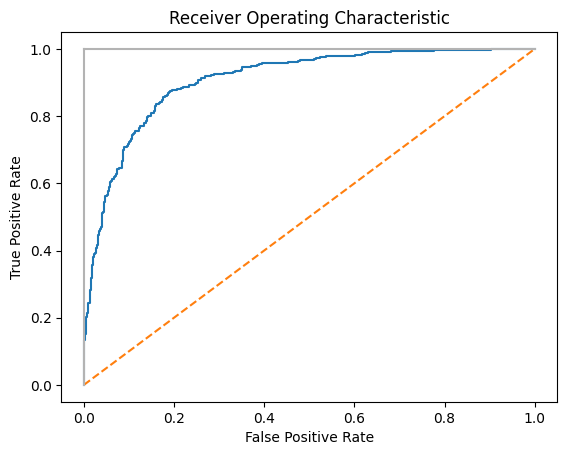

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

features, target = make_classification(n_samples=10000,
                                       n_features=10,
                                       n_classes=2,
                                       n_informative=3,
                                       random_state=3)

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.1, random_state=1)


logit = LogisticRegression()
logit.fit(features_train, target_train)

# obter probabilidades previstas
target_probabilities = logit.predict_proba(features_test)[:, 1]

# calcular taxas de verdadeiros e falsos positivos
false_positive_rate, true_positive_rate, threshold = roc_curve(target_test, target_probabilities)

# curva ROC
plt.title("Receiver Operating Characteristic")
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")  # linha diagonal
plt.plot([0, 0], [1, 0], c=".7")
plt.plot([1, 1], c=".7")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

In [14]:
roc_auc_score(target_test, target_probabilities)

np.float64(0.9073429371748699)

## Visualizing a Classifier’s Performance

### Problema
Dadas as classes previstas e as classes verdadeiras dos dados de teste, você quer comparar visualmente
a qualidade do modelo.

### Solução
Usar uma matriz de confusão, que compara classes previstas e classes verdadeiras.

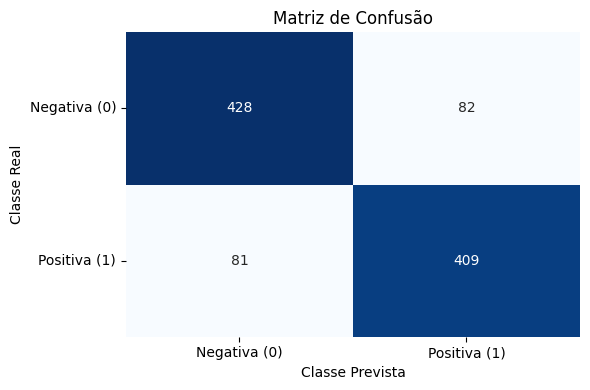

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

target_predicted = logit.predict(features_test)

conf_matrix = confusion_matrix(target_test, target_predicted)

# matriz de confusão
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Matriz de Confusão")
plt.xlabel("Classe Prevista")
plt.ylabel("Classe Real")
plt.xticks([0.5, 1.5], labels=["Negativa (0)", "Positiva (1)"])
plt.yticks([0.5, 1.5], labels=["Negativa (0)", "Positiva (1)"], rotation=0)
plt.tight_layout()
plt.show()

## Evaluating Clustering Models

### Problema
Você aplicou um algoritmo de aprendizado não supervisionado (como K-Means) para agrupar seus dados e agora quer avaliar a qualidade dos agrupamentos obtidos.

### Solução
Como o aprendizado não supervisionado não possui rótulos verdadeiros, não é possível medir diretamente a "exatidão" dos clusters. No entanto, é possível avaliar a **qualidade dos agrupamentos** com o **coeficiente de silhueta (silhouette score)**.

O **silhouette score** mede o quão bem uma amostra está agrupada com outras do mesmo cluster em comparação com amostras de outros clusters. O valor vai de -1 a 1:
- Próximo de **1**: clusters densos e bem separados (ideal).
- Próximo de **0**: clusters sobrepostos.
- Próximo de **-1**: possíveis erros de agrupamento.

In [17]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# dados simulados com 2 clusters
features, _ = make_blobs(n_samples=1000,
                         n_features=10,
                         centers=2,
                         cluster_std=0.5,
                         shuffle=True,
                         random_state=1)

# modelo de clustering (K-Means)
model = KMeans(n_clusters=2, random_state=1)
model.fit(features)

# obter rótulos previstos dos clusters
target_predicted = model.labels_

# avaliar com silhouette score
score = silhouette_score(features, target_predicted)

print(f"Silhouette Score: {score:.4f}")

Silhouette Score: 0.8916
